In [4]:
%pip install obspy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [39]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import os

def estimatePos(rVel, time):
    expecPos = np.empty(len(time))
    expecPos[0] = 0
    for i in range(1, len(time)):
        deltaTime = time[i] - time[i-1]
        acc = (rVel[i] - rVel[i-1]) / deltaTime
        expecPos[i] = expecPos[i-1] + rVel[i-1] * (deltaTime + (0.5 * acc * deltaTime**2))

    return expecPos

def estimateVel(rVel, time):
    expecVel = np.empty(len(time))
    expecVel[0] = 0
    for i in range(1, len(time)):
        deltaTime = time[i] - time[i-1]
        acc = (rVel[i] - rVel[i-1]) / deltaTime
        expecVel[i] = rVel[i-1] + acc * deltaTime

    return expecVel

def estimateNoise(rVel, expecVel):
    obsNoise = np.empty(len(rVel))
    for i in range(len(rVel)):
        obsNoise[i] = rVel[i] - expecVel[i]

    return obsNoise

def maxAcc(rVel, time):
    maxAcc = 0
    for i in range(1, len(time)):
        deltaTime = time[i] - time[i-1]
        acc = (rVel[i] - rVel[i-1]) / deltaTime
        if acc > maxAcc:
            maxAcc = acc

    return maxAcc

def calcMeasurementNoise(rVel, expecVel):
    R  =0
    for i in range(len(rVel)):
        R += (rVel[i] - expecVel[i])**2

    return R/(len(rVel) - 1)

def kalmanFilter(rVel, time):
    # Use independent vectors as state matrix
    x = estimatePos(rVel, time)
    v = estimateVel(rVel, time)

    # Calculate observed noise
    w = estimateNoise(rVel, expecVel)

    # Define Error Covariance Matrix
    Px = np.empty(len(time))
    Pv = np.empty(len(time))
    Px[0] = 0
    Pv[0] = 0

    # Define Predicted Error Covariance Matrix
    PxP = np.empty(len(time))
    PvP = np.empty(len(time))
    PxP[0] = 0
    PvP[0] = 0

    # Define yk
    yx = np.empty(len(time))
    yv = np.empty(len(time))
    yx[0] = 0
    yv[0] = 0

    # Calculate Measurement Noise
    R = calcMeasurementNoise(rVel, expecVel)

    # Define Kalman Gain
    Kx = np.empty(len(time))
    Kv = np.empty(len(time))
    Kx[0] = 0
    Kv[0] = 0

    for i in range(1, len(time)):
        
        deltaTime = time[i] - time[i-1]
        
        # Calculate Noise Process
        Q = (maxAcc(rVel, time)**2) * deltaTime**2

        # Prediction Step
        xP = x[i-1] + v[i-1] * deltaTime
        vP = v[i-1]

        # Predict Error Covariance Matrix
        PxP[i] = (Px[i - 1] + Pv[i - 1]) + (Px[i - 1] + Pv[i - 1]) + Q
        PvP[i] = (deltaTime * Pv[i - 1]) + Pv[i - 1] + Q

        # Update Step
        yx[i] = 0
        yv[i] = rVel[i] - vP

        # Compute Kalman Gain
        Kx[i] = 0
        Kv[i] = PvP[i] / (PvP[i] + R)

        # Update State Matrix
        x[i] = xP
        v[i] = vP + Kv[i] * yv[i]

        # Update Error Covariance Matrix
        Px[i] = 0
        Pv[i] = (1 - Kv[i]) * PvP[i]
    
    return x, v
    

# Load the data
dataset = pd.read_csv("./XB.ELYSE.02.BHV.2022-01-02HR04_evid0006.csv")
relTime = np.array(dataset["rel_time(sec)"].to_list())
obsVel = np.array(dataset["velocity(c/s)"].to_list())

# Compute expected data
expecVel = obsVel
expecPos = estimatePos(expecVel, relTime)

# Apply the Kalman filter
filteredPos, filteredVel = kalmanFilter(obsVel, relTime)

# Detect seismic events in the data and catalogue the in csv file with the following columns: id, abolute time, velocity and position
# Save the data in a csv file
events = []
for i in range(1, len(filteredVel)):
    if filteredVel[i] - filteredVel[i-1] > 0.1:
        events.append([i, relTime[i], filteredVel[i], filteredPos[i]])

events = pd.DataFrame(events, columns=["id", "absolute time", "velocity", "position"])
events
#events.to_csv("seismic_events.csv", index=False)


In [98]:
relTime = np.array(dataset["rel_time(sec)"].to_list())

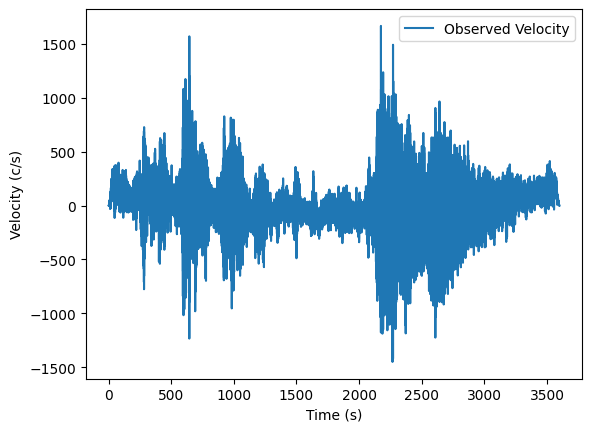

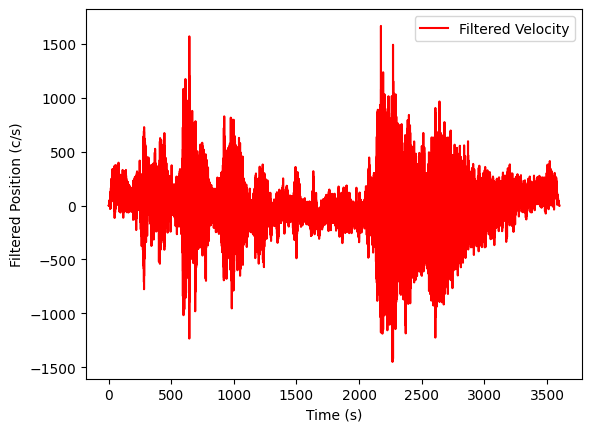

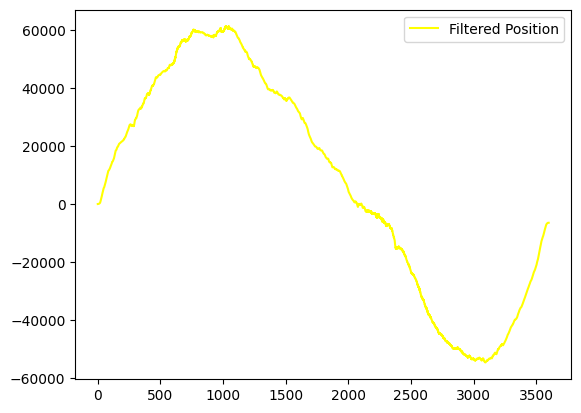

In [102]:
# Plot original data
figure, ax = plt.subplots()
ax.plot(relTime, obsVel, label="Observed Velocity")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Velocity (c/s)")
ax.xlims = (min(relTime), max(relTime))
ax.ylims = (min(obsVel), max(obsVel))
ax.legend()

figure, ax4 = plt.subplots()
ax4.plot(relTime, expecVel, label="Expected Velocity", color="purple")
ax4.set_xlabel("Time (s)")
ax4.set_ylabel("Expected Velocity (c/s)")
ax4.xlims = (min(relTime), max(relTime))
ax4.ylims = (min(expecVel), max(expecVel))
ax4.legend()

figure, ax3 = plt.subplots()
ax3.plot(relTime, expecPos, label="Expected Position", color="green")
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("Expected Position (c/s)")
ax3.xlims = (min(relTime), max(relTime))
ax3.ylims = (min(expecPos), max(expecPos))
ax3.legend()

figure, ax2 = plt.subplots()
ax2.plot(relTime, filteredVel, label="Filtered Velocity", color="red")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Filtered Velocity (c/s)")
ax2.xlims = (min(relTime), max(relTime))
ax2.ylims = (min(filteredVel), max(filteredVel))
ax2.legend()

figure, ax5 = plt.subplots()
ax5.plot(relTime, filteredPos, label="Filtered Position", color="yellow")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Filtered Position (c/s)")
ax5.xlims = (min(relTime), max(relTime))
ax5.ylims = (min(filteredPos), max(filteredPos))
ax5.legend()

plt.show()

# Save the data of each plot in a file for each plot with the following columns: time, velocity/position
# Save the data in a csv file
obsVel = pd.DataFrame(obsVel, columns=["velocity"])
obsVel.to_csv("observed_velocity.csv", index=False)

expecVel = pd.DataFrame(expecVel, columns=["expected_velocity"])
expecVel.to_csv("expected_velocity.csv", index=False)

expecPos = pd.DataFrame(expecPos, columns=["expected_position"])
expecPos.to_csv("expected_position.csv", index=False)

filteredVel = pd.DataFrame(filteredVel, columns=["filtered_velocity"])
filteredVel.to_csv("filtered_velocity.csv", index=False)

filteredPos = pd.DataFrame(filteredPos, columns=["filtered_position"])
filteredPos.to_csv("filtered_position.csv", index=False)

In [103]:
# Create an automatic threshold for the detection of seismic events using extreme values theory

# Compute the mean and standard deviation of the filtered velocity
meanVel = np.mean(filteredVel)
stdVel = np.std(filteredVel)

# Compute the threshold
threshold = meanVel + 8.7 * stdVel

# Detect seismic events in the data and catalogue the in csv file with the following columns: id, abolute time, velocity and position
# Save the data in a csv file
events = []
for i in range(1, len(filteredVel)):
    if filteredVel[i] > threshold:
        # Find the absolute time of the event in the original data
        absTime = dataset["time(%Y-%m-%dT%H:%M:%S.%f)"].iloc[i]

        events.append([i, absTime, filteredVel[i], filteredPos[i]])

events = pd.DataFrame(events, columns=["id", "abolute time", "velocity", "position"])
events

# Save the data in a csv file
events.to_csv("seismic_events.csv", index=False)

c:\Users\ivanr\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


KeyError: 1

In [ ]:
# Predict the next k seconds of the data
k = 5000
relTime = np.array(dataset["rel_time(sec)"].to_list())
obsVel = np.array(dataset["velocity(c/s)"].to_list())
expecVel = obsVel
expecPos = estimatePos(expecVel, relTime)
filteredPos, filteredVel = kalmanFilter(obsVel, relTime)



# Plot the predicted data
figure, ax = plt.subplots(2,1)
ax[0].plot(relTime, vel, label="Predicted Velocity")
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Velocity (c/s)")
ax[0].xlims = (min(relTime), max(relTime))
ax[0].ylims = (min(vel), max(vel))
ax[0].legend()
ax[1].plot(relTime, pos, label="Predicted Position")
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Position (m)")
ax[1].xlims = (min(relTime), max(relTime))
ax[1].ylims = (min(pos), max(pos))
ax[1].legend()
plt.show()